Here we will work on gathering the data using the Jira API to build our CSV with a larger dataset

In [ ]:
import requests
import json
import pandas as pd
from tqdm import tqdm
import os
from dotenv import load_dotenv  # Add python-dotenv for better env management

load_dotenv
BEARER_TOKEN = os.getenv('JIRA_BEARER_TOKEN')
JIRA_URL = 'https://csc.cioxhealth.com'
 
session = requests.Session()
session.headers.update({
    'Authorization': f'Bearer {BEARER_TOKEN}',
    'Content-Type': 'application/json'  # Ensure Content-Type is set to application/json
    })

def login_to_jira():
    response = session.get(JIRA_URL + '/rest/api/2/user?username=SVC_IT_Automation')
    
    if response.status_code == 200:
        print("Successfully logged in to Jira")
        #print(response.json())
        return True
    else:
        print("Failed to log in to Jira")
        print(response.status_code, response.text)
        return False


# Login to JIRA
if not login_to_jira():
    raise Exception("Failed to log in to JIRA")

# Data retrieval variables
start_at = 0
max_results = 100
total = None
fields = ['key', 'project', 'summary', 'description', 'assignee', 'httpUrl', 'customfield_19900', 'customfield_15404', 'customfield_14201']
issues_list = []

# Prepare for progress bar
pbar = tqdm(total=None)  # Total will be updated after first response

# Main loop for data retrieval
while total is None or start_at < total:
    search_data = {
        'jql': "project='29-IT Service Desk' AND status=closed AND created >= startOfYear(-6m)",
        'fields': fields,
        'startAt': start_at,
        'maxResults': max_results
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        if 'issues' in search_result:
            issues_list.extend(search_result['issues'])

        if total is None:
            total = search_result['total']
            pbar.total = total // max_results + (total % max_results > 0)
            pbar.refresh()

        start_at += max_results
        pbar.update(1)

    elif search_response.status_code == 401:
        if not login_to_jira():
            print("Failed to re-authenticate.")
            break

    else:
        print("Received unexpected status code:", search_response.status_code)
        print(search_response.text)
        break

pbar.close()

# Convert collected data to DataFrame
df = pd.json_normalize(issues_list)

We'll save the dataframe to a CSV so that we have a saved copy incase something happens so we don't have to redownload it again.

In [2]:
import datetime

# Save DataFrame to CSV
now = datetime.datetime.now()
df.to_csv(f'dataframe{now:%Y-%m-%d_%H-%M}.csv', index=False)

Lets look at the size and a sample of our dataframe we'll be working with

In [ ]:
size = len(df)
print(f"Dataframe Size: {size:.2f}KB")

print(df.columns)
print(df.sample(5))

Verify GPU


In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Set device to the first CUDA device
    device = torch.device("cuda:0")
    print(f"Using device: {torch.cuda.get_device_name(0)}")

    # Create random tensors
    x = torch.randn(5000, 5000, device=device)
    y = torch.randn(5000, 5000, device=device)

    # Perform matrix multiplication
    print("Performing matrix multiplication on GPU...")
    z = torch.matmul(x, y)

    # The operation is performed on the GPU, so if this script runs without errors
    # and you observe the GPU utilization go up in your system's resource monitor,
    # then the Nvidia A1000 is being used.
    print("Done with matrix multiplication.")

else:
    print("CUDA is not available. Using CPU instead.")


Using device: NVIDIA RTX A1000 Laptop GPU
Performing matrix multiplication on GPU...
Done with matrix multiplication.


This cell is used to reload the dataframe from the CSV

In [2]:
import pandas as pd
# Load CSV
df = pd.read_csv('dataframe2024-11-21_04-29.csv')

In [3]:
# Remove unneeded columns
df = df[[
    'fields.customfield_14201',
    'fields.assignee.displayName',
    'fields.customfield_15404.value',
    'fields.summary',
    'fields.description'
]]

We need to rename the columns to make it more easily understandable

Rename columns

In [4]:
df = df.rename(columns={
    'fields.customfield_14201':'Category 1',
    'fields.assignee.displayName':'Assignee',
    'fields.customfield_15404.value':'IT Group',
    'fields.summary':'Summary',
    'fields.description':'Description'
})

Data Cleaning

In [5]:
import nltk
from nltk.corpus import stopwords
import re

# Download only stopwords if needed
nltk.download('stopwords')

def clean_text(text):
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove stopwords - using simple split() instead of word_tokenize
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([w for w in words if w not in stop_words])
    
    return text

# Clean Summary and Description fields
df['Summary'] = df['Summary'].apply(clean_text)
df['Description'] = df['Description'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
print(df.columns)
print(df.sample(5))

Index(['Category 1', 'Assignee', 'IT Group', 'Summary', 'Description'], dtype='object')
                                               Category 1  \
99790   [{'self': 'https://csc.cioxhealth.com/rest/api...   
26087   [{'self': 'https://csc.cioxhealth.com/rest/api...   
113693  [{'self': 'https://csc.cioxhealth.com/rest/api...   
79740   [{'self': 'https://csc.cioxhealth.com/rest/api...   
18135   [{'self': 'https://csc.cioxhealth.com/rest/api...   

                     Assignee              IT Group  \
99790       SVC_IT_Automation                   NaN   
26087       SVC_IT_Automation                   NaN   
113693      Nichole McPherson  Product Support (PS)   
79740        Jacqueline Brown                  ITSD   
18135   SureshKumar Dillibabu              App- CRI   

                                 Summary  \
99790   healthsource site access request   
26087   healthsource site access request   
113693                   hs sites access   
79740           equipment missing lapt

This is to clean up the code, removing all NaN rows as well as all ITSD rows so only properly assigned tickets are in place.

In [7]:
#drop all rows with IT Group = NaN
df = df.dropna(subset=['IT Group'])

#drop all ITSD tickets
df = df[df['IT Group'] != 'ITSD']

In [8]:
df['IT Group'].unique()

array(['DCO', 'DTO', 'App- CDAI', 'Request Fulfillment',
       'HealthSource CX', 'App- Corp Systems', 'Telecom', 'App- CRI',
       'M365', 'CorpSys - Coupa', 'Digital Grid', 'IAM', 'ReChase',
       'IT Software Licensing', 'DBA', 'EUS', 'NETWORK', 'Virtualization',
       'SOC', 'ARCH', 'Enterprise Tools', 'Healthsource',
       'BI Reporting CDAI', 'Business Intelligence CRI',
       'Infra Engineering', 'App-SmartRequest/Record Hub',
       'Desktop Engineering', 'Privacy Hub', 'HCM', 'CorpSys - NetSuite',
       'Product Support (PS)', 'Salesforce', 'Red Team',
       'Healthcare Integration', 'EDELIVERY', 'App-Arch Support',
       'Automation (RPA)'], dtype=object)

Analyze Class Distribution

Class distribution:
IT Group
DTO                            12634
Product Support (PS)           11035
Request Fulfillment             7061
DCO                             6926
HealthSource CX                 5573
App- Corp Systems               4723
App- CDAI                       4491
ReChase                         2616
M365                            2109
App- CRI                        1861
Digital Grid                    1438
Telecom                         1099
SOC                             1073
IAM                              907
EUS                              840
BI Reporting CDAI                575
IT Software Licensing            476
Enterprise Tools                 390
Virtualization                   356
DBA                              341
Infra Engineering                170
Business Intelligence CRI        160
CorpSys - Coupa                  116
App-SmartRequest/Record Hub       80
NETWORK                           76
App-Arch Support                  59
Desktop E

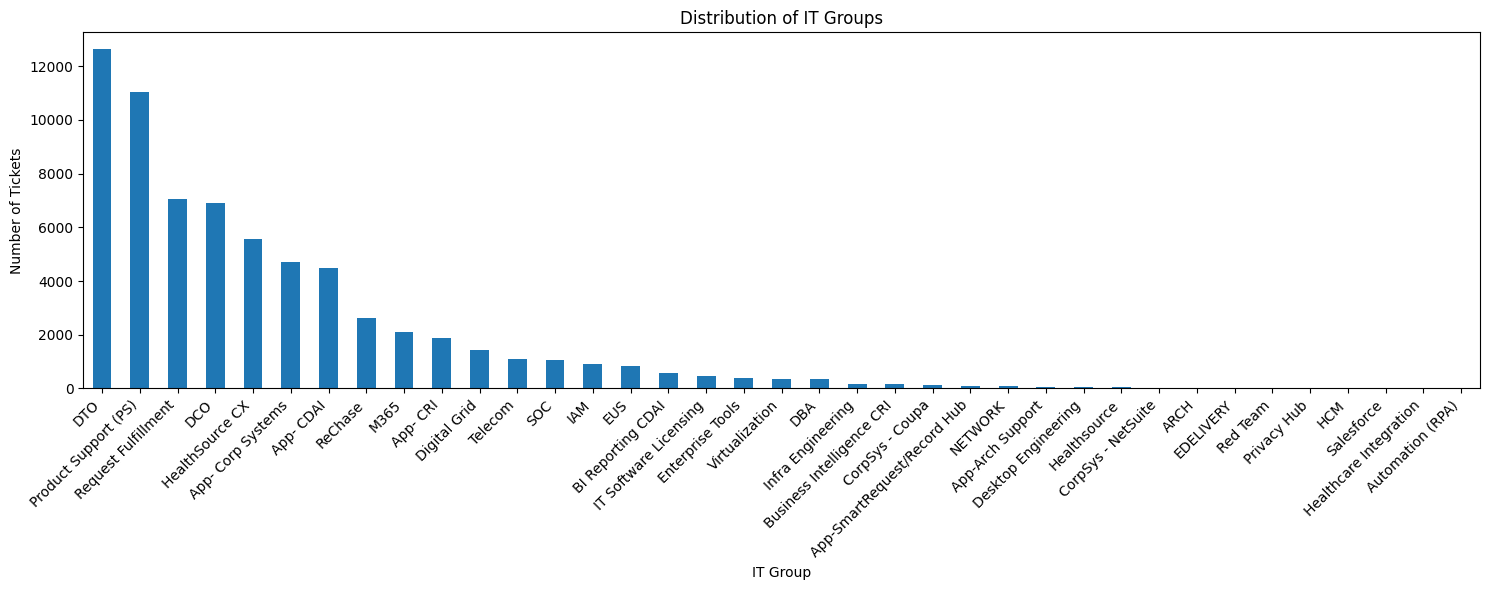

In [9]:
# Analyze class distribution
print("Class distribution:")
print(df['IT Group'].value_counts())
print("\nPercentage distribution:")
print(df['IT Group'].value_counts(normalize=True) * 100)

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
df['IT Group'].value_counts().plot(kind='bar')
plt.title('Distribution of IT Groups')
plt.xlabel('IT Group')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This reduces the dataset to be 20% of the original to fit within memory constraints


In [10]:

#reducing size of dataset
df = df.sample(frac=0.2,random_state=42)

Now we start our work.  We load the dataframe from the CSV, and we'll start filling in empty fields to prevent errors

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import gc

# Combine 'Summary', 'Description', and 'Last Comment Assignee' into one field
#df['combined'] = df[['Summary', 'Description', 'Last Comment Assignee']].fillna('').agg(' '.join, axis=1)
df['combined'] = df[['Summary', 'Description']].fillna('').agg(' '.join, axis=1)

# Drop the original fields
#df = df.drop(['Summary', 'Description', 'Last Comment Assignee'], axis=1)
#df = df.drop(['Summary', 'Description'], axis=1)

# Fill in the blank values in 'IT Group', 'Assignee', 'Category 1', 'Category 2', and 'Category 3'
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
#df[['IT Group', 'Assignee', 'Category 1', 'Category 2', 'Category 3']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1', 'Category 2', 'Category 3']])
df[['IT Group', 'Assignee', 'Category 1']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1']])

In [12]:
import gc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert data types for memory efficiency
# df = df.astype({'col_name': 'category', 'int_col': 'int32', ...})



# Create and fit label encoders
le_it_group = LabelEncoder()
#le_assignee = LabelEncoder()
df['IT Group'] = le_it_group.fit_transform(df['IT Group'])
#df['Assignee'] = le_assignee.fit_transform(df['Assignee'])
print("Label Encoders Completed")

# Drop original columns if they are no longer needed
#df.drop(['IT Group', 'Assignee'], axis=1, inplace=True)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df[['IT Group', 'Assignee']], test_size=0.2, random_state=42)
print("Train/Test split completed")

# Create a pipeline for each category
pipeline_it_group = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', RandomForestClassifier(n_jobs=-1))])
#pipeline_assignee = Pipeline([('tfidf', TfidfVectorizer(max_features=10000)), ('clf', RandomForestClassifier(n_jobs=-1))])
print("Pipelines created")

# Train the models
pipeline_it_group.fit(X_train, y_train['IT Group'])
#pipeline_assignee.fit(X_train, y_train['Assignee'])
print("Training Completed")

# Clear memory
gc.collect()


Label Encoders Completed
Train/Test split completed
Pipelines created
Training Completed


28

Addressing the IT Group class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Keep our existing TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    strip_accents='unicode',
    sublinear_tf=True
)

# Create base pipeline
base_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(
        n_jobs=-1,
        class_weight='balanced',
        random_state=42  # Add for reproducibility
    ))
])

# Expanded parameter grid
param_grid = {
    'clf__n_estimators': [200, 300, 400],
    'clf__max_depth': [20, 30, 40],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],  # Add feature selection strategy
    'clf__bootstrap': [True, False]  # Add bootstrap sampling option
}

# Create and train grid search
grid_search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'  # Explicitly set scoring metric
)

print("Starting grid search...")
grid_search.fit(X_train, y_train['IT Group'])

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model
pipeline_it_group = grid_search.best_estimator_

Testing XGBoost for comparison

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Create pipeline with SMOTE
pipeline_it_group = ImbPipeline([
    ('tfidf', tfidf),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_jobs=-1))
])

In [ ]:
from xgboost import XGBClassifier

print("Starting XGBoost training...")

# Create XGBoost pipeline
xgb_pipeline = Pipeline([
    ('tfidf', tfidf),  # Using same TF-IDF vectorizer as RandomForest
    ('clf', XGBClassifier(
        n_jobs=-1,
        random_state=42,
        tree_method='hist',  # Change from gpu_hist to hist
        device='cuda',       # Add device parameter
        eval_metric='mlogloss',
        #scale_pos_weight=1  # For imbalanced classes
    ))
])

# Ensure the TF-IDF vectorizer is fitted before prediction
tfidf.fit(X_train)  # Fit the vectorizer on training data

# Parameter grid for XGBoost
xgb_param_grid = {
    'clf__n_estimators': [300, 400],     # Match best RF parameters
    'clf__max_depth': [8, 10, 12],       # XGBoost typically uses smaller depths
    'clf__learning_rate': [0.05, 0.1],
    'clf__min_child_weight': [1, 3],
    'clf__subsample': [0.8, 1.0]
}

# Create and train grid search
xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    xgb_param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

print("Starting XGBoost grid search...")
xgb_grid_search.fit(X_train, y_train['IT Group'])

print("\nBest XGBoost parameters:", xgb_grid_search.best_params_)
print("Best XGBoost cross-validation score:", xgb_grid_search.best_score_)

# Get predictions from both models
y_pred_rf = pipeline_it_group.predict(X_test)
y_pred_xgb = xgb_grid_search.best_estimator_.predict(X_test)

# Compare accuracies
print("\nModel Accuracy Comparison:")
print(f"RandomForest: {accuracy_score(y_test['IT Group'], y_pred_rf):.4f}")
print(f"XGBoost:     {accuracy_score(y_test['IT Group'], y_pred_xgb):.4f}")

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred_it_group = pipeline_it_group.predict(X_test)
#y_pred_assignee = pipeline_assignee.predict(X_test)
#y_pred_category1 = pipeline_category1.predict(X_test)
#y_pred_category2 = pipeline_category2.predict(X_test)
#y_pred_category3 = pipeline_category3.predict(X_test)

# Calculate accuracy scores
accuracy_it_group = accuracy_score(y_test['IT Group'], y_pred_it_group)
#accuracy_assignee = accuracy_score(y_test['Assignee'], y_pred_assignee)
#accuracy_category1 = accuracy_score(y_test['Category 1'], y_pred_category1)
#accuracy_category2 = accuracy_score(y_test['Category 2'], y_pred_category2)
#accuracy_category3 = accuracy_score(y_test['Category 3'], y_pred_category3)

print(f"Accuracy of IT Group model: {accuracy_it_group}")
#print(f"Accuracy of Assignee model: {accuracy_assignee}")
#print(f"Accuracy of Category 1 model: {accuracy_category1}")
#print(f"Accuracy of Category 2 model: {accuracy_category2}")
#print(f"Accuracy of Category 3 model: {accuracy_category3}")


In [140]:
new_data = pd.DataFrame({
    'Summary': ['This is a new summary.'],
    'Description': ['This is a new description.'],
    'Last Comment Assignee': ['This is a new last comment.'],
})


Evaluate model accuracy

In [ ]:
# Create a DataFrame with actual values
df_actual = y_test.copy()

# Convert encoded labels back to original labels
df_actual['IT Group'] = le_it_group.inverse_transform(df_actual['IT Group'])
#df_actual['Assignee'] = le_assignee.inverse_transform(df_actual['Assignee'])
#df_actual['Category 1'] = le_category1.inverse_transform(df_actual['Category 1'])
#df_actual['Category 2'] = le_category2.inverse_transform(df_actual['Category 2'])
#df_actual['Category 3'] = le_category3.inverse_transform(df_actual['Category 3'])

# Create a DataFrame with predicted values
df_predicted = pd.DataFrame({
    'IT Group': le_it_group.inverse_transform(y_pred_it_group),
    #'Assignee': le_assignee.inverse_transform(y_pred_assignee),
#    'Category 1': le_category1.inverse_transform(y_pred_category1),
#    'Category 2': le_category2.inverse_transform(y_pred_category2),
#    'Category 3': le_category3.inverse_transform(y_pred_category3),
}, index=y_test.index)

pd.set_option('display.max_colwidth', None)  # or a large number instead of None
pd.set_option('display.width', None)  # or a large number instead of None

# Concatenate the actual and predicted values for comparison
df_comparison = pd.concat([df_actual, df_predicted], axis=1)

# Rename columns for clarity
df_comparison.columns = ['IT Group (actual)', 'Assignee (actual)', 'IT Group (predicted)']

# Display a sample
print(df_comparison.sample(10))


In [13]:
# First, predict the IT Group
predicted_group = pipeline_it_group.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score

# First, predict the IT Group
predicted_group = pipeline_it_group.predict(X_test)

# Calculate accuracy for IT Group
it_group_accuracy = accuracy_score(y_test['IT Group'], predicted_group)
print(f"IT Group Accuracy: {it_group_accuracy * 100:.2f}%")



In [ ]:
from transformers import T5ForConditionalGeneration, T5TokenizerFast
import torch

# Load pre-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5TokenizerFast.from_pretrained('t5-base')

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Move the model to the GPU if available
model = model.to(device)

# Function to generate summary
def generate_summary(text):
    # Prepend 'summarize: ' to the text (T5 model convention for summarization tasks)
    text = "summarize: " + text

    # Tokenize the text
    inputs = tokenizer.encode(text, return_tensors='pt', max_length=512, truncation=True)

    # Move the inputs to the GPU if available
    inputs = inputs.to(device)

    # Generate a summary
    summary_ids = model.generate(inputs, max_length=100, length_penalty=5., num_beams=2)

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

print("Filling NaN with empty strings")
# Fill NaN values with empty strings
df['Summary'].fillna('', inplace=True)
df['Description'].fillna('', inplace=True)

# Combine 'Summary' and 'Description' fields and apply the function to generate summaries
# Note: For demonstration purposes, we're only applying this to the first 10 rows using .head(10)
# Remove .head(10) to apply the function to the entire DataFrame
print("Combining Summary and Description")
df['combined'] = df[['Summary', 'Description']].head(10).agg(' '.join, axis=1)

print("Converting 'combined' column to string")
# Convert the 'combined' column to string type
df['combined'] = df['combined'].astype(str)

print("generating summaries")
df['AI_Summary'] = df['combined'].apply(generate_summary)

# Show a sample
print(df[['Summary', 'Description', 'AI_Summary']].head(10))


In [ ]:
df.to_csv('dataframe.csv', index=False)

DO NOT PROCEED

In [15]:
def search_jira_ticket(ticket_number):
    if not login_to_jira():
        raise Exception("Failed to log in to JIRA")

    search_data = {
        'jql': f"issue = {ticket_number}",
        'fields': ['summary', 'description', 'assignee', 'customfield_19900', 'customfield_15404', 'customfield_14201'],
        'startAt': 0,
        'maxResults': 1
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        return pd.json_normalize(search_result['issues'])
    else:
        print("Failed to retrieve the ticket:", search_response.status_code)
        print(search_response.text)
        return None


In [ ]:
def predict_it_group(ticket_number):
    df_ticket = search_jira_ticket(ticket_number)
    if df_ticket is not None and not df_ticket.empty:
        # Assuming you need 'summary' and 'description' to predict IT group
        combined_field = df_ticket['fields.summary'] + ' ' + df_ticket['fields.description']
        predicted_group_encoded = pipeline_it_group.predict(combined_field)
        predicted_group = le_it_group.inverse_transform(predicted_group_encoded)
        return predicted_group[0]
    else:
        return "Ticket not found or error in retrieval"

# Example usage
ticket_number = "ITSD-602049"
predicted_group = predict_it_group(ticket_number)
print(f"Predicted IT Group for ticket {ticket_number}: {predicted_group}")


In [ ]:
def search_jira_unassigned_tickets_in_group(group_name):
    if not login_to_jira():
        raise Exception("Failed to log in to JIRA")

    # Modify the JQL query
    search_data = {
        'jql': f"project='29-IT Service Desk' AND 'IT Group' = '{group_name}' AND status != closed",
        'fields': ['key', 'summary', 'description', 'assignee', 'customfield_19900', 'customfield_15404', 'customfield_14201'],
        'startAt': 0,
        'maxResults': 100  # You can adjust the maxResults as needed
    }

    search_response = session.post(
        f"{JIRA_URL}/rest/api/2/search",
        data=json.dumps(search_data),
        timeout=300
    )

    if search_response.status_code == 200:
        search_result = search_response.json()
        #return pd.json_normalize(search_result['issues'])
    else:
        print("Failed to retrieve tickets:", search_response.status_code)
        print(search_response.text)
        return None

# Example usage
group_name = "M365"
unassigned_tickets_df = search_jira_unassigned_tickets_in_group(group_name)
print(unassigned_tickets_df)


In [ ]:
def validate_and_suggest_it_group(group_name):
    df_tickets = search_jira_unassigned_tickets_in_group(group_name)
    if df_tickets is not None and not df_tickets.empty:
        # Assuming 'summary' and 'description' fields are used for prediction
        combined_fields = df_tickets['fields.summary'] + ' ' + df_tickets['fields.description']

        # Predict IT Group
        predicted_groups_encoded = pipeline_it_group.predict(combined_fields)
        predicted_groups = le_it_group.inverse_transform(predicted_groups_encoded)

        # Compare and Suggest
        suggestions = []
        for index, row in df_tickets.iterrows():
            predicted_group = predicted_groups[index]
            if predicted_group != group_name:
                suggestions.append({'Ticket': row['key'], 'Current Group': group_name, 'Suggested Group': predicted_group})
        
        return suggestions
    else:
        return "No tickets found or error in retrieval"

# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group(group_name)

if isinstance(suggestions, list) and len(suggestions) > 0:
    print("Suggestions for reassignment:")
    for suggestion in suggestions:
        print(f"Ticket {suggestion['Ticket']} should be in '{suggestion['Suggested Group']}' instead of '{suggestion['Current Group']}'")
else:
    print(suggestions)


In [ ]:
def validate_and_suggest_it_group_with_confidence(group_name, confidence_threshold=0.20):
    df_tickets = search_jira_unassigned_tickets_in_group(group_name)
    if df_tickets is not None and not df_tickets.empty:
        # Assuming 'summary' and 'description' fields are used for prediction
        # Fill NaN values with an empty string or some default text
        df_tickets['fields.summary'].fillna('', inplace=True)
        df_tickets['fields.description'].fillna('', inplace=True)

        combined_fields = df_tickets['fields.summary'] + ' ' + df_tickets['fields.description']

        # Get Predicted Probabilities
        predicted_probs = pipeline_it_group.predict_proba(combined_fields)
        predicted_groups_encoded = pipeline_it_group.predict(combined_fields)
        predicted_groups = le_it_group.inverse_transform(predicted_groups_encoded)

        # Extract the highest probability as the confidence score
        confidence_scores = predicted_probs.max(axis=1)

        # Base URL for JIRA tickets
        jira_ticket_base_url = "https://csc.cioxhealth.com/browse/"

        # Compare, Suggest and Include Confidence Score and URL
        suggestions = []
        for index, row in df_tickets.iterrows():
            predicted_group = predicted_groups[index]
            confidence_score = confidence_scores[index]

            # Create a URL to the ticket
            ticket_url = jira_ticket_base_url + row['key']

            # Only suggest reassignment if confidence is greater than the threshold
            if confidence_score > confidence_threshold and predicted_group != group_name:
                suggestions.append({
                    'Ticket': f"[{row['key']}]({ticket_url})",
                    'Current Group': group_name,
                    'Suggested Group': predicted_group,
                    'Confidence Score': confidence_score
                })

        # Sort suggestions by confidence score in descending order
        sorted_suggestions = sorted(suggestions, key=lambda x: x['Confidence Score'], reverse=True)
        
        return sorted_suggestions
    else:
        return "No tickets found or error in retrieval"

# Example usage
group_name = "M365"
suggestions = validate_and_suggest_it_group_with_confidence(group_name)

if isinstance(suggestions, list) and len(suggestions) > 0:
    print("Suggestions for reassignment with confidence scores and links to JIRA, sorted by confidence:")
    for suggestion in suggestions:
        print(f"Ticket {suggestion['Ticket']} should be in '{suggestion['Suggested Group']}' instead of '{suggestion['Current Group']}' with confidence score: {suggestion['Confidence Score']:.2f}")
else:
    print(suggestions)
